# NIST Table Plots
## Bash NIST compile cmd

In [1]:
! ./compileAndRunFrvt.sh

[MAKE] ./config folder..
mkdir: cannot create directory ‘config’: File exists
[MAKE] ./detectFail folder..
mkdir: cannot create directory ‘detectFail’: File exists
[MAKE] ./FAR folder..
mkdir: cannot create directory ‘FAR’: File exists
[MAKE] ./FRR folder..
mkdir: cannot create directory ‘FRR’: File exists
[DELETE] ./build files..
[DELETE] ./src/nullImpl/build files..
[DELETE] ./detectFail files..
[DELETE] ./FAR files..
[DELETE] ./FRR files..
[DELETE] ./FDresults files..
[DELETE] ./validation files..
[EXECUTE] ./scripts/build_null_impl.sh..
Attempting to build null implementation
[DEBUG] Include headers: CMAKE_CURRENT_SOURCE_DIR{/home/joytsay/frvt/11/src/nullImpl}
[DEBUG] lib_dir{/home/joytsay/frvt/11/src/nullImpl/../../lib}
[DEBUG] Libraries: opencv_imgcodecs{/home/joytsay/frvt/11/lib/libopencv_imgcodecs.so} opencv_imgproc{/home/joytsay/frvt/11/lib/libopencv_imgproc.so} dlib{/home/joytsay/frvt/11/lib/libdlib.so} tf{/home/joytsay/frvt/11/lib/libtensorflow.so} tf_framework{/home/joytsay

## Read log results

In [38]:
import os
import numpy as np
import io
import shutil

def load_index_lists(data_dir,file_name):
    with open(os.path.join(data_dir,file_name),"r") as f:
        lines = f.readlines()
        lines = [l.strip('\n') for l in lines]
        imgPath = ([l.strip().split(' ')[1] for l in lines])
        imgPath.pop(0)
        imgName = ([p.strip().split('/')[3] for p in imgPath])
        noExtImgName = [n.strip(".ppm") for n in imgName]
        enrollId = ([n.strip().split('-')[0] for n in noExtImgName])
    return enrollId, imgName

def load_score_lists(data_dir,file_name):
    with open(os.path.join(data_dir,file_name),"r") as f:
        lines = f.readlines()
        lines = [l.strip('\n') for l in lines]
        score = ([l.strip().split(' ')[2] for l in lines])
        score.pop(0)
    return score                

## FAR FRR 

In [ ]:
    try:
        mode=int(input('Give FR confidence threshold: '))
    except ValueError:
        print ("Not a int number")
    FRconfidence = float(mode*0.01)
    knownToUnknown = 0
    unknownToKnown = 0
    Known = 0
    Unknown = 0
    FR_data_dir = "validation"
    FR_img_dir = "../common/images"
    FAR_dir = "FAR"
    FRR_dir = "FRR"
    enrollId, enrollImg= load_index_lists(FR_data_dir,"enroll.log")
    verifId, verifImg = load_index_lists(FR_data_dir,"verif.log")
    matchScore = load_score_lists(FR_data_dir, "match.log")          
    for i, score in enumerate(matchScore):
        if float(score) >= FRconfidence:
            if enrollId[i] == verifId[i]:
                Known += 1
            else:
                unknownToKnown += 1
                enrollDestFileName = str(unknownToKnown) + "_enrollLine(" + str(i+2) + ")_score("  + str(score) + ")_" + enrollImg[i]
                shutil.copy(os.path.join(FR_img_dir,enrollImg[i]), 
                    os.path.join(FAR_dir,enrollDestFileName))
                verifDestFileName = str(unknownToKnown) + "_verifLine(" + str(i+2) + ")_score("  + str(score) + ")_" + verifImg[i]
                shutil.copy(os.path.join(FR_img_dir,verifImg[i]),
                    os.path.join(FAR_dir,verifDestFileName))
        else:
            if enrollId[i] != verifId[i]:
                Unknown += 1
            else:
                knownToUnknown += 1
                enrollDestFileName = str(knownToUnknown) + "_enrollLine(" + str(i+2) + ")_score("  + str(score) + ")_" + enrollImg[i]
                shutil.copy(os.path.join(FR_img_dir,enrollImg[i]), 
                    os.path.join(FRR_dir,enrollDestFileName))
                verifDestFileName = str(knownToUnknown) + "_verifLine(" + str(i+2) + ")_score("  + str(score) + ")_" + verifImg[i]
                shutil.copy(os.path.join(FR_img_dir,verifImg[i]),
                    os.path.join(FRR_dir,verifDestFileName))
    print("\n[SUCCESS] NIST frvt validation for confidence: ",FRconfidence,
    "\nAll count: ", len(matchScore),
    "\nGenuine: ", Known, 
    "\nImposter: ", Unknown,
    "\nknownToUnknown: ", knownToUnknown, 
    "\nunknownToKnown", unknownToKnown,
    "\nFMR: ", unknownToKnown/len(matchScore)*100,
    "%\nFNMR: ", knownToUnknown/len(matchScore)*100,"%\n")

## plot score against G & I

In [7]:
import matplotlib.pyplot as plt

genuineScore = []
imposterScore = []
genuineX = []
imposterX = []
X=[]
Y=[]
for i, score in enumerate(matchScore):
    if enrollId[i] == verifId[i]: #Genuine
        genuineScore.append(score);
    else:                         #Imposter
        imposterScore.append(score);

        Score    Labels
0    0.956168   Genuine
1    0.892694   Genuine
2    0.872319   Genuine
3    0.869555   Genuine
4    0.770609   Genuine
..        ...       ...
259  0.380889  Imposter
260  0.479654  Imposter
261  0.529690  Imposter
262  0.560929  Imposter
263  0.700000  Imposter

[653 rows x 2 columns]


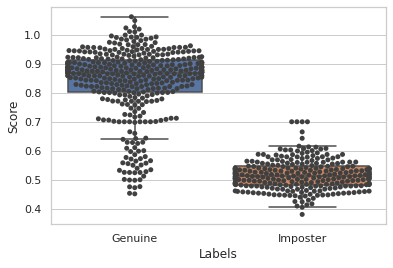

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


sns.set(style="whitegrid")
dfG = pd.DataFrame(genuineScore,columns=['Score'])
dfG['Labels'] = 'Genuine'
# print(dfG)
dfI = pd.DataFrame(imposterScore,columns=['Score'])
dfI['Labels'] = 'Imposter'
# print(dfI)
frames = [dfG, dfI]
result = pd.concat(frames)
result.Score = pd.to_numeric(result.Score, errors='coerce')
print(result)
ax = sns.boxplot(x="Labels", y="Score", data=result, showfliers = False)
ax = sns.swarmplot(x="Labels", y="Score", data=result, color=".25")
plt.savefig('GIboxPlot.png')
plt.show()

## get outliers from bos stats

In [11]:
from matplotlib.cbook import boxplot_stats  
dfG.Score = pd.to_numeric(dfG.Score, errors='coerce')
statsG = boxplot_stats(dfG['Score'])
print('Genuine: ',statsG,'\n')
print(statsG[0]['whislo'])
dfI.Score = pd.to_numeric(dfI.Score, errors='coerce')
statsI = boxplot_stats(dfI['Score'])
print('Imposter: ',statsI)

Genuine:  [{'mean': 0.8363118611825194, 'iqr': 0.110213, 'cilo': 0.8604558071541979, 'cihi': 0.8780021928458024, 'whishi': 1.06172, 'whislo': 0.639466, 'fliers': array([0.525375, 0.586731, 0.475923, 0.532648, 0.512593, 0.597349,
       0.525762, 0.500348, 0.565886, 0.501472, 0.557424, 0.473002,
       0.499313, 0.572967, 0.571686, 0.577057, 0.629207, 0.550963,
       0.625409, 0.558548, 0.564565, 0.498526, 0.611005, 0.600634,
       0.555792, 0.60871 , 0.528134, 0.550199, 0.629565, 0.53477 ,
       0.57997 , 0.598773, 0.451715, 0.453642, 0.628589, 0.476665,
       0.539742, 0.524535, 0.525401]), 'q1': 0.800905, 'med': 0.8692290000000001, 'q3': 0.911118}] 

0.639466
Imposter:  [{'mean': 0.5175483787878787, 'iqr': 0.06354924999999995, 'cilo': 0.5076549380325022, 'cihi': 0.519936061967498, 'whishi': 0.61603, 'whislo': 0.405457, 'fliers': array([0.380889, 0.643001, 0.7     , 0.665159, 0.7     , 0.7     ,
       0.7     ]), 'q1': 0.4826805, 'med': 0.5137955000000001, 'q3': 0.54622975}]


## copy outliers image to GenuineOutliers & ImposterOutliers

In [12]:
    FRconfidence = float(mode*0.01)
    GOCount = 0
    IOCount = 0
    FZCount = 0
    Known = 0
    Unknown = 0
    FR_data_dir = "validation"
    FR_img_dir = "../common/images"
    GO_dir = "GenuineOutliers"
    GF_dir = "GenuineFuzzy"
    IO_dir = "ImposterOutliers"
    enrollId, enrollImg= load_index_lists(FR_data_dir,"enroll.log")
    verifId, verifImg = load_index_lists(FR_data_dir,"verif.log")
    matchScore = load_score_lists(FR_data_dir, "match.log")          
    #        if float(score) >= FRconfidence: statsG[0]['whislo'])
    for i, score in enumerate(matchScore):
        if enrollId[i] == verifId[i]: #Genuine
            if float(score) <= statsG[0]['whislo']: #Outliers
                GOCount += 1
                enrollDestFileName = str(GOCount) + "_enrollLine(" + str(i+2) + ")_score("  + str(score) + ")_" + enrollImg[i]
                shutil.copy(os.path.join(FR_img_dir,enrollImg[i]), 
                    os.path.join(GO_dir,enrollDestFileName))
                verifDestFileName = str(GOCount) + "_verifLine(" + str(i+2) + ")_score("  + str(score) + ")_" + verifImg[i]
                shutil.copy(os.path.join(FR_img_dir,verifImg[i]),
                    os.path.join(GO_dir,verifDestFileName))
            if float(score) >= statsG[0]['whislo'] and float(score) <= statsG[0]['q1']: #Fuzzy
                FZCount += 1
                enrollDestFileName = str(FZCount) + "_enrollLine(" + str(i+2) + ")_score("  + str(score) + ")_" + enrollImg[i]
                shutil.copy(os.path.join(FR_img_dir,enrollImg[i]), 
                    os.path.join(GF_dir,enrollDestFileName))
                verifDestFileName = str(FZCount) + "_verifLine(" + str(i+2) + ")_score("  + str(score) + ")_" + verifImg[i]
                shutil.copy(os.path.join(FR_img_dir,verifImg[i]),
                    os.path.join(GF_dir,verifDestFileName))
        else:                         #Imposter
            if float(score) >= statsI[0]['whishi']: #Outliers
                IOCount += 1
                enrollDestFileName = str(IOCount) + "_enrollLine(" + str(i+2) + ")_score("  + str(score) + ")_" + enrollImg[i]
                shutil.copy(os.path.join(FR_img_dir,enrollImg[i]), 
                    os.path.join(IO_dir,enrollDestFileName))
                verifDestFileName = str(IOCount) + "_verifLine(" + str(i+2) + ")_score("  + str(score) + ")_" + verifImg[i]
                shutil.copy(os.path.join(FR_img_dir,verifImg[i]),
                    os.path.join(IO_dir,verifDestFileName))

## pnas convert jpeg to ppm

In [36]:
from PIL import Image


myimages = [] #list of image filenames
dirFiles = os.listdir('pnas') #list of directory files
dirFiles.sort() #good initial sort but doesnt sort numerically very well
sorted(dirFiles) #sort numerically in ascending order

for files in dirFiles: #filter out all non jpgs
    if '.jpg' in files:
        myimages.append(files)

for i, imgName in enumerate(myimages):
    srcImgName = 'pnas/' + imgName
    im = Image.open(srcImgName)
    destImgName = 'pnas/ppm/'+ str(i+1) +'.ppm'
    im.save(destImgName)

## parse pnas directory

       Score    Labels
0   0.652037   Genuine
1   0.747998   Genuine
2   0.808165   Genuine
3   0.737049   Genuine
4   0.641822   Genuine
5   0.700000   Genuine
6   0.720472   Genuine
7   0.705777   Genuine
8   0.808612   Genuine
9   0.680086   Genuine
10  0.615062   Genuine
11  0.700000   Genuine
0   0.624768  Imposter
1   0.750409  Imposter
2   0.524893  Imposter
3   0.547640  Imposter
4   0.623339  Imposter
5   0.514997  Imposter
6   0.579765  Imposter
7   0.662683  Imposter


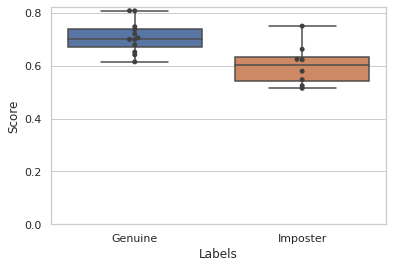

Genuine:  [{'mean': 0.7097566666666667, 'iqr': 0.06671250000000006, 'cilo': 0.6726530633308494, 'cihi': 0.7331239366691507, 'whishi': 0.808612, 'whislo': 0.615062, 'fliers': array([], dtype=float64), 'q1': 0.6730737499999999, 'med': 0.7028885, 'q3': 0.73978625}] 

0.615062
Imposter:  [{'mean': 0.60356175, 'iqr': 0.09229349999999992, 'cilo': 0.5503218326280892, 'cihi': 0.652782167371911, 'whishi': 0.750409, 'whislo': 0.514997, 'fliers': array([], dtype=float64), 'q1': 0.54195325, 'med': 0.6015520000000001, 'q3': 0.63424675}]


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def load_index_lists(data_dir,file_name):
    with open(os.path.join(data_dir,file_name),"r") as f:
        lines = f.readlines()
        lines = [l.strip('\n') for l in lines]
        imgPath = ([l.strip().split(' ')[1] for l in lines])
        imgPath.pop(0)
        imgName = ([p.strip().split('/')[2] for p in imgPath])
        noExtImgName = [n.strip(".ppm") for n in imgName]
        enrollId = ([n.strip().split('-')[0] for n in noExtImgName])
    return enrollId, imgName

def load_score_lists(data_dir,file_name):
    with open(os.path.join(data_dir,file_name),"r") as f:
        lines = f.readlines()
        lines = [l.strip('\n') for l in lines]
        score = ([l.strip().split(' ')[2] for l in lines])
        score.pop(0)
    return score       

genuineScore = []
imposterScore = []
genuineX = []
imposterX = []
X=[]
Y=[]
knownToUnknown = 0
unknownToKnown = 0
Known = 0
Unknown = 0
FR_data_dir = "validation"
FR_img_dir = "pnas/ppm"
FAR_dir = "FAR"
FRR_dir = "FRR"
enrollId, enrollImg= load_index_lists(FR_data_dir,"enroll.log")
verifId, verifImg = load_index_lists(FR_data_dir,"verif.log")
matchScore = load_score_lists(FR_data_dir, "match.log")      


for i, score in enumerate(matchScore):
    if i < 12: #Genuine
        genuineScore.append(score);
    else:                         #Imposter
        imposterScore.append(score);
        
sns.set(style="whitegrid")
dfG = pd.DataFrame(genuineScore,columns=['Score'])
dfG['Labels'] = 'Genuine'
# print(dfG)
dfI = pd.DataFrame(imposterScore,columns=['Score'])
dfI['Labels'] = 'Imposter'
# print(dfI)
frames = [dfG, dfI]
result = pd.concat(frames)
result.Score = pd.to_numeric(result.Score, errors='coerce')
print(result)
ax = sns.boxplot(x="Labels", y="Score", data=result, showfliers = False)
ax = sns.swarmplot(x="Labels", y="Score", data=result, color=".25")
plt.yticks(np.arange(0, 1, 0.2))
plt.savefig('GIboxPlot.png')
plt.show()

from matplotlib.cbook import boxplot_stats  
dfG.Score = pd.to_numeric(dfG.Score, errors='coerce')
statsG = boxplot_stats(dfG['Score'])
print('Genuine: ',statsG,'\n')
print(statsG[0]['whislo'])
dfI.Score = pd.to_numeric(dfI.Score, errors='coerce')
statsI = boxplot_stats(dfI['Score'])
print('Imposter: ',statsI)

GO_dir = 'pnasResult'
GOCount = 0
for i, score in enumerate(matchScore):
    GOCount += 1
    enrollDestFileName = str(GOCount) + "_enrollLine(" + str(i+2) + ")_score("  + str(score) + ")_" + enrollImg[i]
    shutil.copy(os.path.join(FR_img_dir,enrollImg[i]), 
        os.path.join(GO_dir,enrollDestFileName))
    verifDestFileName = str(GOCount) + "_verifLine(" + str(i+2) + ")_score("  + str(score) + ")_" + verifImg[i]
    shutil.copy(os.path.join(FR_img_dir,verifImg[i]),
        os.path.join(GO_dir,verifDestFileName))


## for pre test FAR

In [54]:
from PIL import Image


myimages = [] #list of image filenames
dirFiles = os.listdir('preTestFAR') #list of directory files
dirFiles.sort() #good initial sort but doesnt sort numerically very well
sorted(dirFiles) #sort numerically in ascending order

for files in dirFiles: #filter out all non jpgs
    if '.jpg' in files:
        myimages.append(files)

for i, imgName in enumerate(myimages):
    srcImgName = 'preTestFAR/' + imgName
    im = Image.open(srcImgName)
    destImgName = 'preTestFAR/ppm/'+ str(i+1) +'.ppm'
    im.save(destImgName)

In [55]:
! ./run_validate_11.sh

Checking installation of required packages [SUCCESS]
Looking for core implementation library in /home/joytsay/frvt/11/lib.[SUCCESS] Found core implementation library /home/joytsay/frvt/11/lib/libfrvt_11_geo_000.so.
Attempting to compile and link /home/joytsay/frvt/11/lib/libfrvt_11_geo_000.so against test harness.
Scanning dependencies of target validate11
[ 50%] Building CXX object src/testdriver/CMakeFiles/validate11.dir/home/joytsay/frvt/common/src/util/util.cpp.o
[100%] Building CXX object src/testdriver/CMakeFiles/validate11.dir/validate11.cpp.o
Linking CXX executable ../../../bin/validate11
[100%] Built target validate11
[SUCCESS] Built executable in /home/joytsay/frvt/11/bin.
------------------------------
 Running 1:1 validation
------------------------------
Checking for hard-coded config directory 2020-08-06 06:37:25.892758: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-08

      Score   Labels
0  0.499929  Genuine
1  0.508477  Genuine
2  0.508477  Genuine
3  0.449163  Genuine


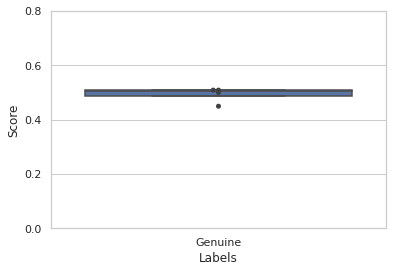

Genuine:  [{'mean': 0.49151150000000005, 'iqr': 0.021239500000000078, 'cilo': 0.4875299925, 'cihi': 0.5208760075000002, 'whishi': 0.5084770000000001, 'whislo': 0.4872375, 'fliers': array([0.449163]), 'q1': 0.4872375, 'med': 0.5042030000000001, 'q3': 0.5084770000000001}] 

0.4872375
Imposter:  [{'fliers': array([], dtype=float64), 'mean': nan, 'med': nan, 'q1': nan, 'q3': nan, 'cilo': nan, 'cihi': nan, 'whislo': nan, 'whishi': nan}]


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def load_index_lists(data_dir,file_name):
    with open(os.path.join(data_dir,file_name),"r") as f:
        lines = f.readlines()
        lines = [l.strip('\n') for l in lines]
        imgPath = ([l.strip().split(' ')[1] for l in lines])
        imgPath.pop(0)
        imgName = ([p.strip().split('/')[2] for p in imgPath])
        noExtImgName = [n.strip(".ppm") for n in imgName]
        enrollId = ([n.strip().split('-')[0] for n in noExtImgName])
    return enrollId, imgName

def load_score_lists(data_dir,file_name):
    with open(os.path.join(data_dir,file_name),"r") as f:
        lines = f.readlines()
        lines = [l.strip('\n') for l in lines]
        score = ([l.strip().split(' ')[2] for l in lines])
        score.pop(0)
    return score       

genuineScore = []
imposterScore = []
genuineX = []
imposterX = []
X=[]
Y=[]
knownToUnknown = 0
unknownToKnown = 0
Known = 0
Unknown = 0
FR_data_dir = "validation"
FR_img_dir = "preTestFAR/ppm"
FAR_dir = "FAR"
FRR_dir = "FRR"
enrollId, enrollImg= load_index_lists(FR_data_dir,"enroll.log")
verifId, verifImg = load_index_lists(FR_data_dir,"verif.log")
matchScore = load_score_lists(FR_data_dir, "match.log")      


for i, score in enumerate(matchScore):
    if i < 12: #Genuine
        genuineScore.append(score);
    else:                         #Imposter
        imposterScore.append(score);
        
sns.set(style="whitegrid")
dfG = pd.DataFrame(genuineScore,columns=['Score'])
dfG['Labels'] = 'Genuine'
# print(dfG)
dfI = pd.DataFrame(imposterScore,columns=['Score'])
dfI['Labels'] = 'Imposter'
# print(dfI)
frames = [dfG, dfI]
result = pd.concat(frames)
result.Score = pd.to_numeric(result.Score, errors='coerce')
print(result)
ax = sns.boxplot(x="Labels", y="Score", data=result, showfliers = False)
ax = sns.swarmplot(x="Labels", y="Score", data=result, color=".25")
plt.yticks(np.arange(0, 1, 0.2))
plt.savefig('GIboxPlot.png')
plt.show()

from matplotlib.cbook import boxplot_stats  
dfG.Score = pd.to_numeric(dfG.Score, errors='coerce')
statsG = boxplot_stats(dfG['Score'])
print('Genuine: ',statsG,'\n')
print(statsG[0]['whislo'])
dfI.Score = pd.to_numeric(dfI.Score, errors='coerce')
statsI = boxplot_stats(dfI['Score'])
print('Imposter: ',statsI)

GO_dir = 'preTestFARresult'
GOCount = 0
for i, score in enumerate(matchScore):
    GOCount += 1
    enrollDestFileName = str(GOCount) + "_enrollLine(" + str(i+2) + ")_score("  + str(score) + ")_" + enrollImg[i]
    shutil.copy(os.path.join(FR_img_dir,enrollImg[i]), 
        os.path.join(GO_dir,enrollDestFileName))
    verifDestFileName = str(GOCount) + "_verifLine(" + str(i+2) + ")_score("  + str(score) + ")_" + verifImg[i]
    shutil.copy(os.path.join(FR_img_dir,verifImg[i]),
        os.path.join(GO_dir,verifDestFileName))
